# 2. Exploratory Data Analysis
In this section, we explore the basic structure of the dataset and look for patterns
that may influence the clustering process.

## 1 Imports and configurations
### 1.1 In first lines loading libraries

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from CONST.consts import PATH_RAW_DATA

### 1.2 Loading data

In [89]:
df = pd.read_csv( PATH_RAW_DATA, index_col=0 )

### 1.3 Basic Dataset Statistics (Number of Rows, Columns, etc.)

In [90]:
df.head(5)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [91]:
print(df.columns)

Index(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


| Column Name | Description |
| :--- | :--- |
| **Id** | Row ID. |
| **ProductId** | Unique identifier for the product. |
| **UserId** | Unique identifier for the user. |
| **ProfileName** | Profile name of the user. |
| **HelpfulnessNumerator** | Number of users who found the review helpful. |
| **HelpfulnessDenominator** | Number of users who indicated whether they found the review helpful or not (Denominator = Helpful + Not Helpful). |
| **Score** | Rating between 1 and 5 (Stars). |
| **Time** | Timestamp for the review (Unix time). |
| **Summary** | A brief summary of the review (Headline). |
| **Text** | The full body of the review. |

In [92]:
df.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568454 entries, 1 to 568454
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ProductId               568454 non-null  object
 1   UserId                  568454 non-null  object
 2   ProfileName             568428 non-null  object
 3   HelpfulnessNumerator    568454 non-null  int64 
 4   HelpfulnessDenominator  568454 non-null  int64 
 5   Score                   568454 non-null  int64 
 6   Time                    568454 non-null  int64 
 7   Summary                 568427 non-null  object
 8   Text                    568454 non-null  object
dtypes: int64(4), object(5)
memory usage: 43.4+ MB


In [94]:
data = pd.DataFrame({
    "DataType": df.dtypes,
    "UniqueValues": df.nunique(),
    "MissingValues": df.isnull().sum(),
})
print(f"Number of values date {df.shape[0]}")
desc = df.describe().T[['mean', 'std', 'min', 'max']]
summary = pd.concat( [ data, desc ], axis = 1 )
print(data)


Number of values date 568454
                       DataType  UniqueValues  MissingValues
ProductId                object         74258              0
UserId                   object        256059              0
ProfileName              object        218415             26
HelpfulnessNumerator      int64           231              0
HelpfulnessDenominator    int64           234              0
Score                     int64             5              0
Time                      int64          3168              0
Summary                  object        295742             27
Text                     object        393579              0


In [95]:
duplicates = df.duplicated(subset=['UserId', 'ProductId', 'Text', 'Time']).sum()
print(f"Number of identical duplicates: {duplicates}")

Number of identical duplicates: 1205


### Removing Duplicates (Some users may have posted the same text for different products)


In [96]:
df = df.drop_duplicates(subset=['UserId', 'ProductId', 'Text', 'Time'], keep='first')
duplicates = df.duplicated(subset=['UserId', 'ProductId', 'Text', 'Time']).sum()
print(f"Number of identical duplicates: {duplicates}")

Number of identical duplicates: 0


In [97]:
near_duplicates = df.duplicated(subset=['UserId', 'Text', 'Time']).sum()
print(f"Number of opinions from the same user for different products: {near_duplicates}")

Number of opinions from the same user for different products: 173357


In [98]:
df = df.drop_duplicates( subset=["UserId", "Text", "Time"], keep='first' )
duplicates = df.duplicated(subset=["UserId", "Text", "Time"]).sum()
print(f"Number of identical duplicates: {duplicates}")

Number of identical duplicates: 0


### Distribution Plots for Numerical Columns

We visualize the distributions of all numerical columns to identify skewness, outliers, and patterns that may affect modeling.

In [99]:
print(f"Numerical columns {df.select_dtypes( include=["number"]).columns.tolist() }")
num_cols = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time']

Numerical columns ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time']


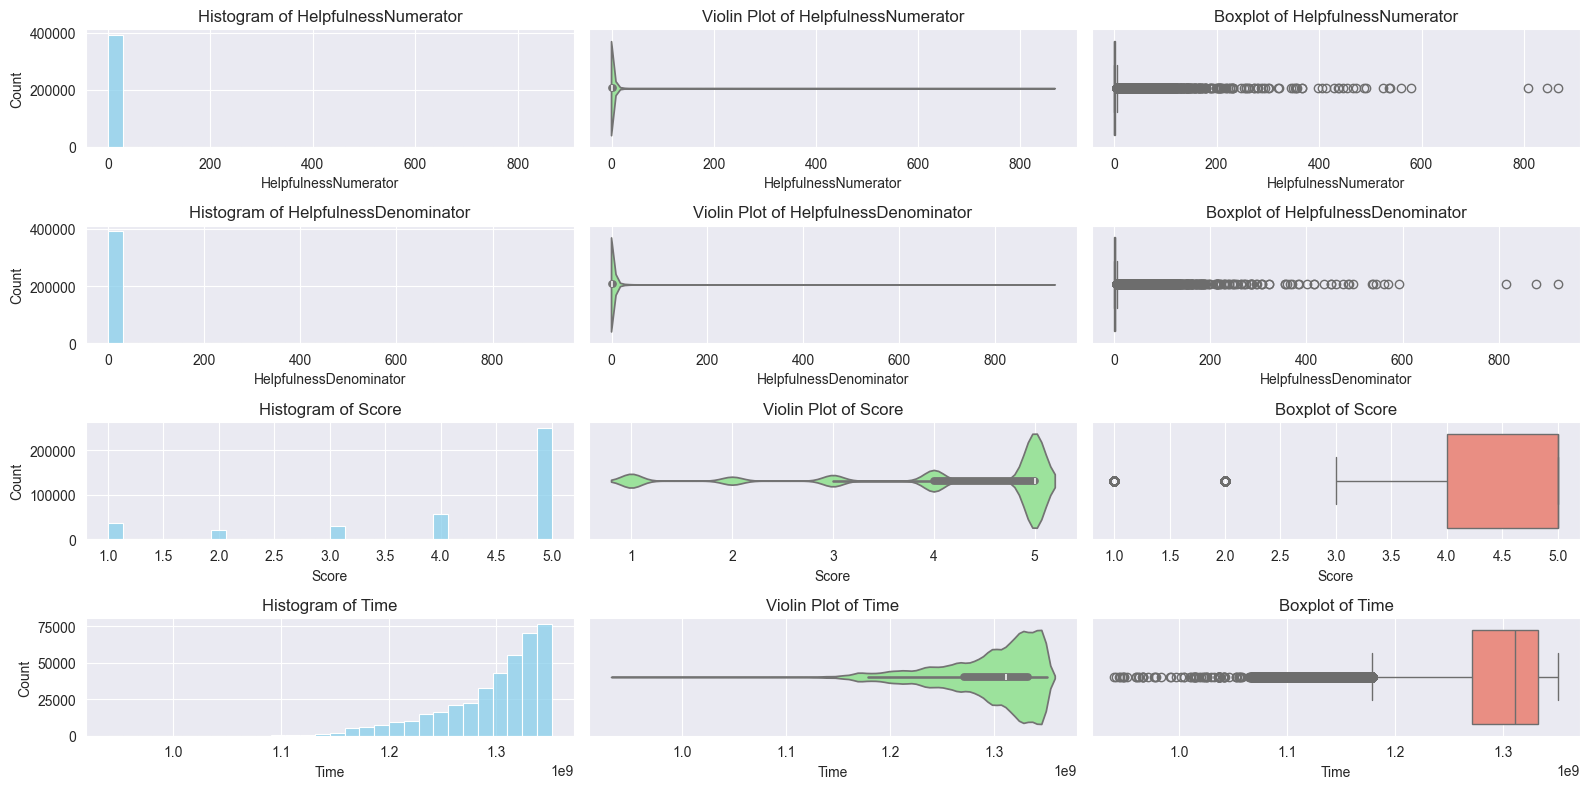

In [101]:
fig, axes = plt.subplots( 4, 3 , figsize = ( 16,8 ) )

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, ax=axes[i, 0], kde=False, color='skyblue')
    axes[i, 0].set_title(f'Histogram of {col}')
    sns.violinplot(x=df[col], ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'Violin Plot of {col}')
    sns.boxplot(x=df[col], ax=axes[i, 2], color='salmon')
    axes[i, 2].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


#### **Key Observations:**

1.  **Helpfulness Features (`HelpfulnessNumerator` & `HelpfulnessDenominator`):**
    *   **Extreme Skewness:** Both features are heavily right-skewed. The vast majority of reviews have zero or very few helpfulness votes.
    *   **Outliers:** The Boxplots and Violin plots reveal significant outliers (values exceeding 800). These represent a tiny fraction of reviews that became highly viral or controversial.
    *   **Action:** For clustering, these features might need scaling or transformation (like Log Scaling) if we decide to use them as features.

2.  **Ratings (`Score`):**
    *   **Imbalance:** The dataset is highly imbalanced towards positive reviews. 5-star ratings are the most frequent, followed by 4-star ratings.
    *   **Sentiment Bias:** This suggests that the "average" sentiment in the dataset is very positive, which we must account for during sentiment analysis and topic modeling.

3.  **Temporal Data (`Time`):**
    *   **Growth Trend:** The distribution shows a significant increase in the number of reviews over time (Unix timestamp). The density is highest in the later periods of the dataset.
    *   **Note:** The `Time` variable is currently shown in Unix format. Converting this to a standard `datetime` format will allow for better seasonal and yearly analysis.


#### **Conclusion for the Project:**
*   Most users are satisfied (high scores), but negative reviews, although fewer, might contain more specific complaints (important for clustering).
*   The high number of outliers in "Helpfulness" suggests that only a small percentage of the community actively engages in voting on reviews.
*   Data cleaning (removing duplicates) was crucial, as many identical reviews likely contributed to these skewed distributions.


### Matrix of Pearson Linear Correlation Coefficients


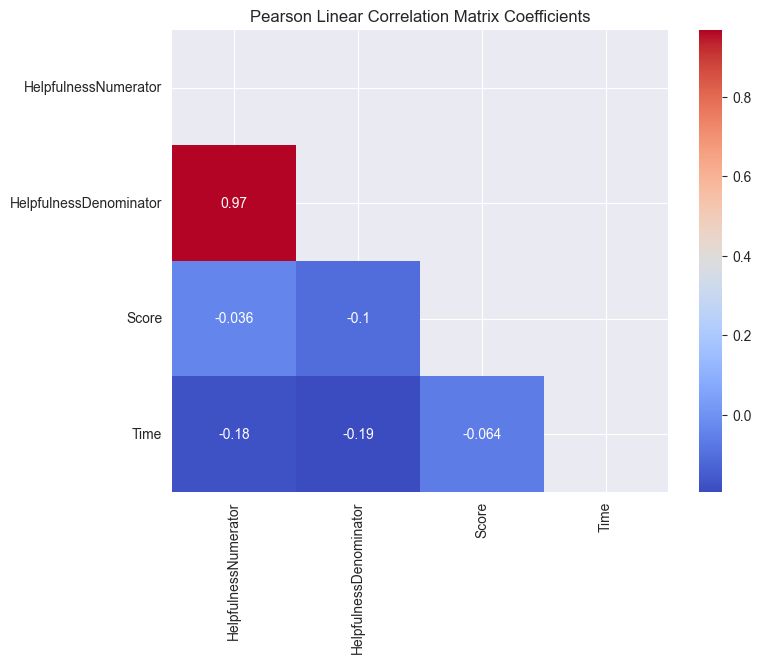

In [114]:
correlation = df[num_cols].corr(method = 'pearson')
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig, axes = plt.subplots(1,1, figsize = (8,6 ))
sns.heatmap( correlation, mask = mask , cmap = 'coolwarm', annot = True )
plt.title("Pearson Linear Correlation Matrix Coefficients")
plt.show()